In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import json

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.cluster import AffinityPropagation, KMeans, SpectralClustering, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle
from functions import get_stations, trips_by_hour, trips_between_minutes
from scipy.spatial import distance

from constants import colors as C
colors = cycle(C)

In [9]:
def affinity_propagation_clustering(data, **kwargs):
    af = AffinityPropagation(**kwargs).fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    
    for i in range(n_clusters_):
        # select only data observations with cluster label == i
        yield data[np.where(labels == i)], data[cluster_centers_indices[i]] 

def k_means_clustering(data, **kwargs):
    kmeans = KMeans(**kwargs)
    kmeans.fit(data)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    for i in range(kwargs['n_clusters']):
        # select only data observations with cluster label == i
        yield data[np.where(labels == i)], centroids[i]

def spectral_clustering(data, **kwargs):
    sc = SpectralClustering(**kwargs)
    sc.fit(data)
    
    labels = sc.labels_
    
    for i in range(kwargs['n_clusters']):
        # select only data observations with cluster label == i
        yield data[np.where(labels == i)]

def agglomerative_clustering(data, **kwargs):
    sc = AgglomerativeClustering(**kwargs)
    sc.fit(data)
    
    labels = sc.labels_
    
    for i in range(kwargs['n_clusters']):
        # select only data observations with cluster label == i
        yield data[np.where(labels == i)]

def gen_balanca_data(trips, df):
    def balance(row):
        sign = lambda x: (1, -1)[x<0]
        return max((row.llegadas, row.salidas)) / (min((row.llegadas, row.salidas)) or 1) * sign(row.llegadas - row.salidas)

    df['lat'] = df.location.apply(lambda x: float(x.split(',')[0])*100)
    df['lon'] = df.location.apply(lambda x: float(x.split(',')[1])*100)
    df['salidas'] = df.apply(lambda row: len(trips[trips.departure_station == row['id']].index), axis=1)
    df['llegadas'] = df.apply(lambda row: len(trips[trips.arrival_station == row['id']].index), axis=1)
    df['balance'] = df.apply(lambda row: balance(row), axis=1)
#     max_balance = df.balance.max()
#     min_balance = df.balance.min()
#     # Revisar esto!!!!!!!
#     df.balance = df.balance.apply(lambda x: ((x - min_balance) / ((max_balance - min_balance) /2)) - 1)
#     df.balance = df.balance.apply(lambda x: x / 10)

def gen_balanca_data_abs(trips, df):
    def balance(row):
        sign = lambda x: (1, -1)[x<0]
        return max((row.llegadas, row.salidas)) / (min((row.llegadas, row.salidas)) or 1) * sign(row.llegadas - row.salidas)

    df['lat'] = df.location.apply(lambda x: float(x.split(',')[0]))
    df['lon'] = df.location.apply(lambda x: float(x.split(',')[1]))
    df['viajes'] = df.apply(lambda row: len(trips[(trips.departure_station == row['id']) | (trips.arrival_station == row['id'])].index), axis=1)
    max_viajes = df.viajes.max()
    df['viajes'] = df.viajes.apply(lambda x: (x / max_viajes) / 10)
    

In [3]:
stations = get_stations()
salidas_15 = json.load(open('data/salidas_2015.json'))
llegadas_15 = json.load(open('data/llegadas_2015.json'))

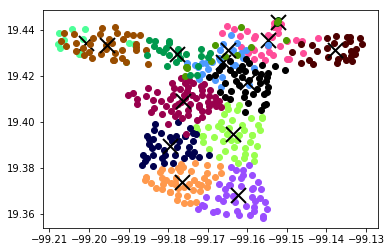

In [33]:
# stations = get_stations()
gen_balanca_data_abs(trips_by_hour(7,2016), stations)

for datum, centroid in k_means_clustering(stations[['lon','lat', 'viajes']].as_matrix(), n_clusters=14):
    plt.plot(datum[:, 0], datum[:, 1], 'o', color=next(colors))
    # plot the centroids
    lines = plt.plot(centroid[0], centroid[1], 'kx')
    # make the centroid x's bigger
    plt.setp(lines, ms=15.0)
    plt.setp(lines, mew=2.0)
plt.show(block=False)

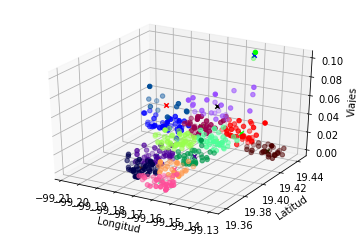

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for datum, centroid in k_means_clustering(stations[['lon','lat', 'viajes']].as_matrix(), n_clusters=14):
    ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors))
    # plot the centroids
    ax.scatter(centroid[0], centroid[1], centroid[2], marker='x', color=next(colors), alpha=1, linewidths=2)

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Viajes')
plt.show(block=False)

In [35]:
# Guardar cuales estaciones pertenecen a cual cluster
i = 0
res = {}
for datum, centroid in k_means_clustering(stations[['lon','lat', 'viajes']].as_matrix(), n_clusters=14):
    res[str(i)] = []
    for d in datum:
        res[str(i)] += [int(stations[stations.viajes == d[2]].id.iloc[0])]
    i += 1

with open('clusters_list.json', 'w') as fp:
    json.dump(res, fp)

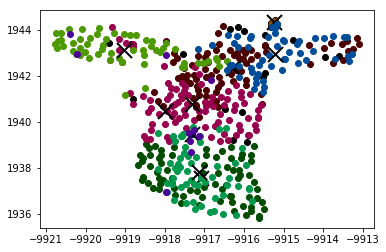

In [4]:
# Plot K-means in 2D
# stations = get_stations()
gen_balanca_data(trips_by_hour(7,2015), stations)

for datum, centroid in k_means_clustering(stations[['lon','lat', 'balance']].as_matrix(), 10):
    plt.plot(datum[:, 0], datum[:, 1], 'o', color=next(colors))
    # plot the centroids
    lines = plt.plot(centroid[0], centroid[1], 'kx')
    # make the centroid x's bigger
    plt.setp(lines, ms=15.0)
    plt.setp(lines, mew=2.0)
plt.show(block=False)

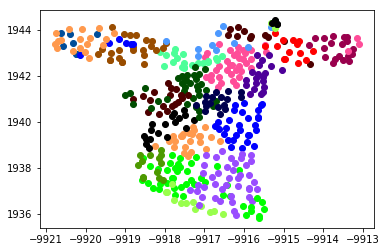

In [53]:
# Plot Affinity Propagation in 2D
# stations = get_stations()
# gen_balanca_data(trips_by_hour(7,2015), stations)

for datum in agglomerative_clustering(stations[['lon','lat', 'balance']].as_matrix(), n_clusters=30):
    plt.plot(datum[:, 0], datum[:, 1], 'o', color=next(colors))
    # plot the centroids
#     lines = plt.plot(centroid[0], centroid[1], 'kx')
    # make the centroid x's bigger
#     plt.setp(lines, ms=15.0)
#     plt.setp(lines, mew=2.0)
plt.show(block=False)

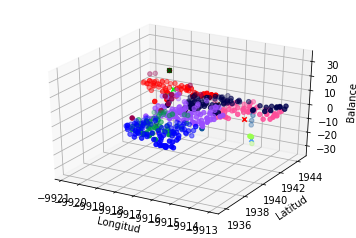

In [5]:
# 3D plot of K means
hourly_trips = trips_by_hour(7,2015)
gen_balanca_data(trips_by_hour(7,2015), stations)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for datum, centroid in k_means_clustering(stations[['lon','lat', 'balance']].as_matrix(), 10):
    ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors))
    # plot the centroids
    ax.scatter(centroid[0], centroid[1], centroid[2], marker='x', color=next(colors), alpha=1, linewidths=2)

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Balance')
plt.show(block=False)

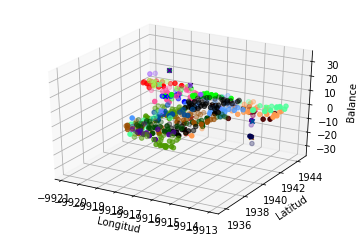

In [7]:
# 3D plot of Affinity Propagation
trips = trips_by_hour(7,2015)
gen_balanca_data(trips, stations)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clusters = 0
for datum, centroid in affinity_propagation_clustering(stations[['lon','lat', 'balance']].as_matrix()):
    ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors))
    # plot the centroids
    ax.scatter(centroid[0], centroid[1], centroid[2], marker='x', color=next(colors), alpha=1, linewidths=2)
    clusters += 1

fig.canvas.set_window_title('Clusters: %s' % clusters)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Balance')
plt.show(block=False)

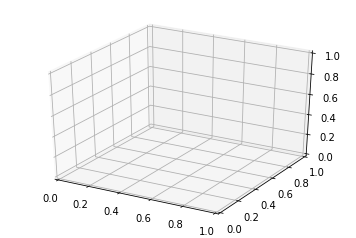

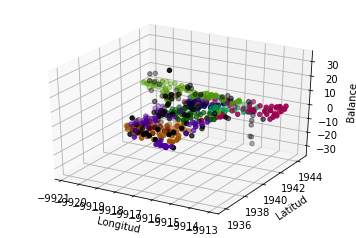

In [11]:
# 3D plot of Spectral Clustering
trips = trips_by_hour(7,2015)
gen_balanca_data(trips, stations)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clusters = 0
for datum in spectral_clustering(stations[['lon','lat', 'balance']].as_matrix(), n_clusters=10):
    ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors))
    clusters += 1

fig.canvas.set_window_title('Clusters: %s' % clusters)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Balance')
plt.show(block=False)

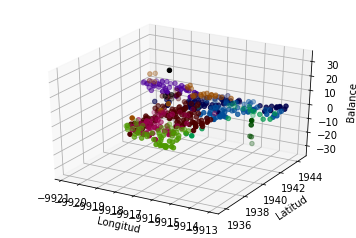

In [14]:
# 3D plot of Agglomerative Clustering
trips = trips_by_hour(7,2015)
gen_balanca_data(trips, stations)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clusters = 0
for datum in agglomerative_clustering(stations[['lon','lat', 'balance']].as_matrix(), n_clusters=22):
    ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors))
    clusters += 1

fig.canvas.set_window_title('Clusters: %s' % clusters)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Balance')
plt.show(block=False)

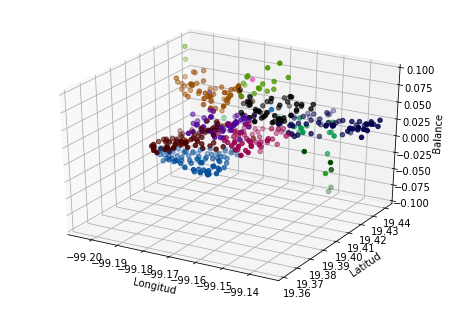

In [5]:
# 3D plot K means animation every hour
total_data = []

# Generate all data
for i in range(7, 24):
    hourly_trips = trips_by_hour(i,2015)
    gen_balanca_data(hourly_trips, stations)
    total_data.append(stations[['lon','lat', 'balance']].as_matrix())

# Function for animation
def update_lines(num):
    global fig
    global scat
    global data

    for s2 in scat_centroids:
        s2.remove()
    
#     for s1, s2 in zip(scat_stations, scat_centroids):
#         s1.remove()
#         s2.remove()
    
    for i, (datum, centroid) in enumerate(k_means_clustering(total_data[num], 10)):
#         scat_stations[i] = ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=C[i])
        # plot the centroids
        scat_centroids[i] = ax.scatter(centroid[0], centroid[1], centroid[2], marker='x', color=C[i], alpha=1, linewidths=2)

    # scat.remove()
    fig.canvas.set_window_title('%s - %s' % (num + 7, num + 8))
    # scat = ax.scatter(data[num][:,0], data[num][:,1], data[num][:,2])
    return  scat_centroids

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Setting the axes properties
ax.set_xlim3d([-99.207808, -99.130918])  # Min, max lon values
ax.set_xlabel('Longitud')

ax.set_ylim3d([19.35827, 19.444031])  # Min, max lat values
ax.set_ylabel('Latitud')

ax.set_zlim3d([-.10, .10])
ax.set_zlabel('Balance')

scat_stations, scat_centroids = [], []
for datum, centroid in k_means_clustering(stations[['lon','lat', 'balance']].as_matrix(), 10):
#     scat_stations.append(ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors)))
    # plot the centroids
    scat_centroids.append(ax.scatter(centroid[0], centroid[1], centroid[2], 'kx'))

# scat = [ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2])]
    
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, len(total_data), interval=1500)


plt.show()

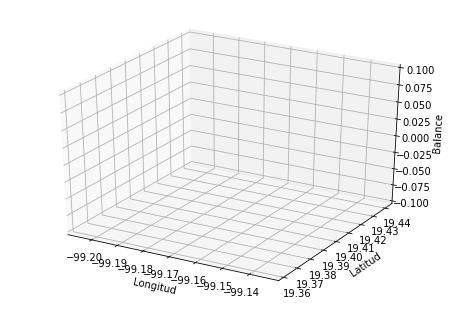

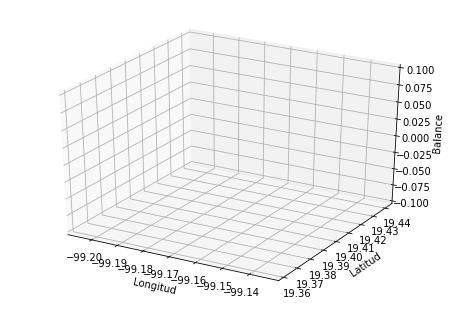

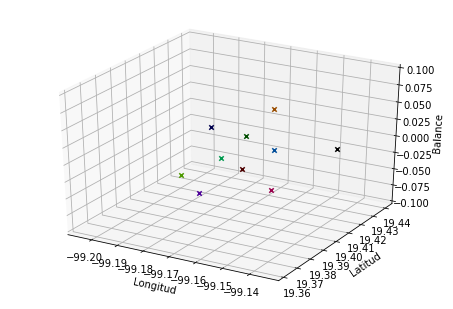

In [6]:
# 3D plot K means animation every 5 minutes
# total_data = []

# # Generate all data
# start = datetime(2018, 1, 1, hour=5, minute=0)
# for i in range(228):
#     end = start + timedelta(minutes=5)
#     trips = trips_between_minutes(start.hour, start.minute, end.hour, end.minute, 2015)
#     gen_balanca_data(trips, stations)
#     total_data.append(stations[['lon','lat', 'balance']].fillna(value=0).as_matrix())
#     start = end

# Function for animation
def update_lines(num):
    global fig
    global scat
    global data

    for s2 in scat_centroids:
        s2.remove()
    
#     for s1, s2 in zip(scat_stations, scat_centroids):
#         s1.remove()
#         s2.remove()
    
    for i, (datum, centroid) in enumerate(k_means_clustering(total_data[num], 10)):
#         scat_stations[i] = ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=C[i])
        # plot the centroids
        scat_centroids[i] = ax.scatter(centroid[0], centroid[1], centroid[2], marker='x', color=C[i], alpha=1, linewidths=2)

    # scat.remove()
    fig.canvas.set_window_title('%s - %s' % (num + 7, num + 8))
    # scat = ax.scatter(data[num][:,0], data[num][:,1], data[num][:,2])
    return  scat_centroids

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Setting the axes properties
ax.set_xlim3d([-99.207808, -99.130918])  # Min, max lon values
ax.set_xlabel('Longitud')

ax.set_ylim3d([19.35827, 19.444031])  # Min, max lat values
ax.set_ylabel('Latitud')

ax.set_zlim3d([-.10, .10])
ax.set_zlabel('Balance')

scat_stations, scat_centroids = [], []
for datum, centroid in k_means_clustering(stations[['lon','lat', 'balance']].fillna(value=0).as_matrix(), 10):
#     scat_stations.append(ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors)))
    # plot the centroids
    scat_centroids.append(ax.scatter(centroid[0], centroid[1], centroid[2], 'kx'))

# scat = [ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2])]
    
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, len(total_data), interval=1500)


plt.show()

In [46]:
# Find best clusters for first timelapse
MAX_CLUSTERS = 150

bal_1_k_means = []
bal_1_spectral = []
bal_1_agglomerative = []

# Generate all data
start = datetime(2018, 1, 1, hour=5, minute=0)
end = datetime(2018, 1, 1, hour=13, minute=0)
trips = trips_between_minutes(start.hour, start.minute, end.hour, end.minute, 2015)
gen_balanca_data(trips, stations)

# Progress Bar
pbar = tqdm(total=MAX_CLUSTERS - 1)
for i in range(1, MAX_CLUSTERS):
    pbar.update()
    # K means
    k = k_means_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_1_k_means.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d, c in k])
    # Spectral Clustering
    s = spectral_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_1_spectral.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d in s])
    # Agglomerative Clustering
    a = agglomerative_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_1_agglomerative.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d in a])

pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [02:26<00:00,  1.85s/it]


In [47]:
# Find best clusters for second timelapse
MAX_CLUSTERS = 150

bal_2_k_means = []
bal_2_spectral = []
bal_2_agglomerative = []

# Generate all data
start = datetime(2018, 1, 1, hour=13, minute=30)
end = datetime(2018, 1, 1, hour=17, minute=30)
trips = trips_between_minutes(start.hour, start.minute, end.hour, end.minute, 2015)
gen_balanca_data(trips, stations)

# Progress Bar
pbar = tqdm(total=MAX_CLUSTERS - 1)
for i in range(1, MAX_CLUSTERS):
    pbar.update()
    # K means
    k = k_means_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_2_k_means.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d, c in k])
    # Spectral Clustering
    s = spectral_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_2_spectral.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d in s])
    # Agglomerative Clustering
    a = agglomerative_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_2_agglomerative.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d in a])

pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [02:25<00:00,  1.91s/it]


In [48]:
# Find best clusters for second timelapse
MAX_CLUSTERS = 150

bal_3_k_means = []
bal_3_spectral = []
bal_3_agglomerative = []

# Generate all data
start = datetime(2018, 1, 1, hour=17, minute=30)
end = datetime(2018, 1, 1, hour=23, minute=59)
trips = trips_between_minutes(start.hour, start.minute, end.hour, end.minute, 2015)
gen_balanca_data(trips, stations)

# Progress Bar
pbar = tqdm(total=MAX_CLUSTERS - 1)
for i in range(1, MAX_CLUSTERS):
    pbar.update()
    # K means
    k = k_means_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_3_k_means.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d, c in k])
    # Spectral Clustering
    s = spectral_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_3_spectral.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d in s])
    # Agglomerative Clustering
    a = agglomerative_clustering(stations[['lon','lat']].as_matrix(), n_clusters=i)
    bal_3_agglomerative.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d in a])

pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [02:22<00:00,  1.87s/it]


In [52]:
[np.median(balances) for balances in bal_k_means]

[-131.29056463578286,
 -65.645282317891429,
 -37.768600279236011,
 -33.067043792847983,
 -15.797955393242379,
 -11.751889092455668,
 -15.95825318769279,
 -10.264938062043505,
 -10.828799164704277,
 -6.0302268821273151,
 1.1049291148735438,
 1.2038009877647902,
 -6.6201486026606444,
 -2.9498202874640143,
 -7.4959884524221909,
 -7.1298107496795193,
 -8.6895368395189649,
 -9.4992114142488226,
 -3.2003109657700115,
 -5.6769205276470718,
 -4.5545937048457326,
 -2.0542112906042997,
 -4.3614961645449277,
 -4.595277797941451,
 -4.4826128821726954,
 -0.35567119836018823,
 -3.5317545258990268,
 -1.4095423158871605,
 -6.4786876850119643,
 -4.4587843241828375,
 2.4604606449041184,
 -0.13036175232975555,
 -4.7574778729369189,
 0.51944073784802136,
 -2.6085271049346943,
 0.57012599870457981,
 -2.1447504007444422,
 -1.8247663344895126,
 0.38136733698468972,
 -3.9059779153438874,
 -0.00013312217111538516,
 -0.38344305460881711,
 -2.5568805281313187,
 -0.64440400239395024,
 -1.063994513155613,
 -1.0374

In [54]:
bal_1_k_means

[[-131.29056463578286],
 [-86.225386510763087, -45.065178125019756],
 [-41.150953220412482, 61.104499391586415, -151.24411080695677],
 [-41.565580441976721,
  -127.63980262187562,
  -24.568507143719248,
  62.483325571788718],
 [-15.797955393242379,
  49.120645855582893,
  -75.279735067638597,
  -142.69117220783011,
  53.357652177345322],
 [-131.46512215744116,
  -6.3965330819763881,
  53.357652177345322,
  -75.079289472338701,
  -8.2365304511242563,
  36.529258349752332],
 [-6.4980885198488938,
  -28.362172723609124,
  56.071937891631045,
  32.771492087981663,
  -131.46512215744116,
  -9.8873514691866546,
  -43.921259745309719],
 [-12.068372235311829,
  -146.76435828454066,
  51.000041920157635,
  -21.126103610558275,
  53.357652177345322,
  5.3000637287057684,
  -6.0091229363942249,
  -54.980365395186595],
 [-5.2818502091214983,
  -53.66953468033978,
  -143.55048168981827,
  63.319310023595726,
  -10.301705568645163,
  -9.9514845526659137,
  5.3000637287057684,
  -20.891203959638077,


In [ ]:
# Caso especial
def gen_balanca_data_mod(trips, df):
    def balance(row):
        sign = lambda x: (1, -1)[x<0]
        return max((row.llegadas, row.salidas)) / (min((row.llegadas, row.salidas)) or 1) * sign(row.llegadas - row.salidas)

    df['lat'] = df.location.apply(lambda x: float(x.split(',')[0])*100)
    df['lon'] = df.location.apply(lambda x: float(x.split(',')[1])*100)
    df['salidas'] = df.apply(lambda row: len(trips[trips.departure_station == row['id']].index), axis=1)
    df['llegadas'] = df.apply(lambda row: len(trips[trips.arrival_station == row['id']].index), axis=1)
    df['balance'] = df.apply(lambda row: abs(balance(row)), axis=1)
    
start = datetime(2018, 1, 1, hour=0, minute=1)
end = datetime(2018, 1, 1, hour=23, minute=59)
trips = trips_between_minutes(start.hour, start.minute, end.hour, end.minute, 2015)

k = k_means_clustering(stations[['lon','lat', 'bal']].as_matrix(), n_clusters=i)
bal_3_k_means.append([stations[(stations.lon.isin(d[:,0])) & (stations.lat.isin(d[:,1]))].balance.sum() for d, c in k])

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Setting the axes properties
ax.set_xlim3d([-99.207808, -99.130918])  # Min, max lon values
ax.set_xlabel('Longitud')

ax.set_ylim3d([1935.827, 1944.4031])  # Min, max lat values
ax.set_ylabel('Latitud')

ax.set_zlim3d([-.10, .10])
ax.set_zlabel('Balance')

scat_stations, scat_centroids = [], []
for datum, centroid in k_means_clustering(stations[['lon','lat', 'balance']].fillna(value=0).as_matrix(), 10):
#     scat_stations.append(ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='o', color=next(colors)))
    # plot the centroids
    scat_centroids.append(ax.scatter(centroid[0], centroid[1], centroid[2], 'kx'))

# scat = [ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2])]
plt.show()